The **Moravec operator**, introduced by Hans Moravec in 1977, is one of the earliest corner detection algorithms. It works by testing how similar a local window is to its shifted versions in four directions (horizontal, vertical, and two diagonals).

### The Core Concept

A corner is defined as a point where the image intensity changes significantly in all directions. Moravec’s operator calculates the **Sum of Squared Differences (SSD)** between a patch and its neighbors to determine if a pixel is a corner.

1. **Flat Region:** Shifting the window in any direction results in little to no change in intensity.
2. **Edge:** Shifting along the edge results in little change, but shifting perpendicular to the edge results in a large change.
3. **Corner:** Shifting in **any** direction results in a significant change in intensity.

---

### Step-by-Step Explanation

To calculate the cornerness of a pixel :

1. **Define a Window:** Usually a small  or  patch around the pixel.
2. **Shift the Window:** Move the window by one pixel in four directions:  and .
3. **Calculate SSD:** For each shift , compute the sum of squared differences:


4. **Find the Minimum Change:** The "cornerness" score () is the **minimum** of the four SSD values:



*If the smallest change is still large, it means all directions changed significantly—indicating a corner.*

---

### Python Code Example

Text(0.5, 1.0, 'Moravec Corners')

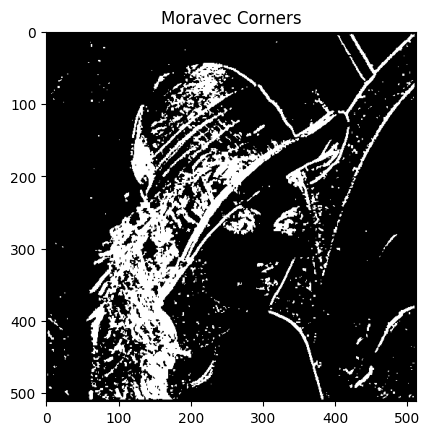

In [10]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

def moravec_corner_detection(img, threshold=1000):
    rows, cols = img.shape
    corner_map = np.zeros_like(img, dtype=np.float32)
    
    # Define shifts (Horizontal, Vertical, Diagonals)
    shifts = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    
    # Iterate through the image (avoiding borders)
    for y in range(2, rows - 2):
        for x in range(2, cols - 2):
            ssd_values = []
            
            # Local 3x3 window
            window = img[y-1:y+2, x-1:x+2].astype(np.float32)
            
            for dy, dx in shifts:
                # Shifted window
                shifted_window = img[y-1+dy:y+2+dy, x-1+dx:x+2+dx].astype(np.float32)
                
                # Calculate SSD
                ssd = np.sum((window - shifted_window) ** 2)
                ssd_values.append(ssd)
            
            # Cornerness is the minimum of the SSD values
            corner_map[y, x] = min(ssd_values)
            
    # Thresholding to find corners
    img_corners = np.zeros_like(img)
    img_corners[corner_map > threshold] = 1
    return img_corners

# --- Example usage ---
image = cv2.imread('resources/lena_gray.png', cv2.IMREAD_GRAYSCALE)
corners = moravec_corner_detection(image, threshold=500)
plt.imshow(corners, cmap='gray')
plt.title("Moravec Corners")

Text(0.5, 1.0, 'Moravec Corners')

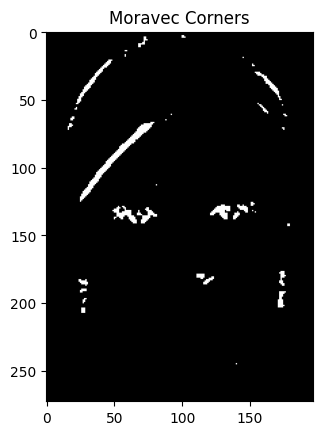

In [9]:

# --- Example usage ---
image = cv2.imread('resources/face.png', cv2.IMREAD_GRAYSCALE)
corners = moravec_corner_detection(image, threshold=500)
plt.imshow(corners, cmap='gray')
plt.title("Moravec Corners")


### Limitations of Moravec

While revolutionary, the Moravec operator has several weaknesses that led to the development of the **Harris Corner Detector** (1988):

* **Anisotropic:** It only checks four discrete directions (). If a corner is oriented at , it might be missed.
* **Noise Sensitivity:** Because it uses a simple square window without smoothing, it is very sensitive to pixel noise.
* **Fixed Window Response:** The response is binary and doesn't handle varying scales well.


# Harris Corner detection
The **Harris Corner Detector** is a direct evolution of the Moravec operator. While Moravec only checks four discrete directions, Harris uses mathematical gradients to account for **all** possible directions, making it much more robust.

### 1. The Improvement over Moravec

Harris improved the Moravec operator in three key ways:

* **Differential Analysis:** It uses the Taylor series expansion to determine how the intensity changes for *any* small shift .
* **Gaussian Weighting:** Instead of a simple square window, it uses a circular Gaussian window to reduce noise sensitivity.
* **Eigenvalue Analysis:** It uses the eigenvalues of a local matrix to distinguish between flat areas, edges, and corners.

---

### 2. The Mathematical Steps

The detector calculates a matrix  (often called the **Structure Tensor**) for every pixel:

Where  and  are the image gradients (derivatives) in the  and  directions.

#### The Harris Response ()

Instead of calculating eigenvalues directly (which is slow), Harris proposed a "Corner Response" function:

$$R = \det(M) - k \cdot (\text{trace}(M))^2$$
$\det(M) = \lambda_1 \lambda_2$

$\text{trace}(M) = \lambda_1 + \lambda_2$

$k$ is an empirical constant (usually  to ).

---

### 3. Interpreting the Result

By looking at the magnitude of the eigenvalues (), we can classify the pixel:

* **Flat Region:** Both  and  are very small ( is small).
* **Edge:** One eigenvalue is large, and the other is small ().
* **Corner:** Both eigenvalues are large ( is large and positive).

---

### 4. Python Implementation (OpenCV)

OpenCV makes this very easy with `cv2.cornerHarris`.


### 5. Summary: Moravec vs. Harris

| Feature | Moravec (1977) | Harris (1988) |
| --- | --- | --- |
| **Directions** | Only 4 discrete shifts | Continuous (all directions) |
| **Window** | Binary Square | Gaussian (Circular) |
| **Noise** | Very Sensitive | Robust |
| **Response** | Minimum SSD | Eigenvalue-based  score |


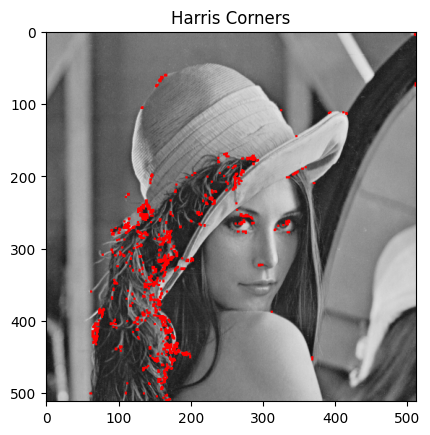

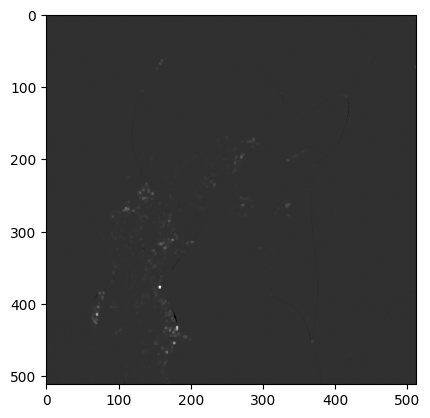

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load image and convert to grayscale
img = cv2.imread('resources/lena_gray.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

# 2. Apply Harris Corner Detection
# blockSize: size of neighborhood (Gaussian window)
# ksize: Aperture parameter for the Sobel operator
# k: Harris detector free parameter
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.05)

# 3. Result is dilated for marking the corners
dst = cv2.dilate(dst, None)

# 4. Threshold for an optimal value, it may vary depending on the image
img[dst > 0.01 * dst.max()] = [0, 0, 255] # Mark in red

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Harris Corners')
plt.show()
plt.imshow(dst, cmap='gray')
plt.show()

The **Shi-Tomasi corner detector** (1994) is a direct modification of the Harris Corner Detector. In their paper *"Good Features to Track,"* Jianbo Shi and Carlo Tomasi showed that a simpler criteria for corner selection often performs better for feature tracking than the original Harris response.

---

### 1. The Key Difference: The Scoring Function

Both Harris and Shi-Tomasi use the same **Structure Tensor (Matrix $M$)**:
$$M = \sum_{x,y} w(x,y) \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{bmatrix}$$

While Harris uses a complex formula involving the determinant and trace ($R = \lambda_1\lambda_2 - k(\lambda_1+\lambda_2)^2$), **Shi-Tomasi** simplifies this to the minimum eigenvalue: $$R = \min(\lambda_1, \lambda_2)$$

#### Why $\min(\lambda_1, \lambda_2)$?

The logic is that a pixel is only a "good" corner if the intensity changes significantly in **both** directions. If the smaller of the two eigenvalues is greater than a threshold ($\min(\lambda_1, \lambda_2) > \lambda_{min}$), then the larger one is guaranteed to be even better.

---

### 2. Why is it "Better"?

Shi-Tomasi's method is widely considered superior for **optical flow** and **feature tracking** because:

* **Uniformity:** It provides a more uniform distribution of corners across the image.
* **Stability:** The features selected are statistically more likely to be tracked successfully between frames in a video.
* **Simplicity:** It removes the need for the sensitivity parameter  used in Harris.

---

### 3. Comparison of Regions

Using eigenvalues $\lambda_1$ and $\lambda_2$ as axes, we can visualize how the two algorithms "see" the image:

| Region | Harris Response | Shi-Tomasi Response |
| --- | --- | --- |
| **Flat** | $\lambda_1, \lambda_2$ are very small |$\min(\lambda_1, \lambda_2) < \text{threshold}$  |
| **Edge** | One $\lambda$ is large, one is small ($R < 0$) | $\min(\lambda_1, \lambda_2) < \text{threshold}$ |
| **Corner** | Both $\lambda$ are large ($R$ is large) | $\min(\lambda_1, \lambda_2) > \text{threshold}$ |

---

### 4. Implementation in Python (OpenCV)

In OpenCV, the Shi-Tomasi detector is implemented via the `cv2.goodFeaturesToTrack()` function. This function is very powerful because it includes built-in **non-maximum suppression** and allows you to specify the maximum number of corners you want.

### 5. Summary Table

| Feature | Harris | Shi-Tomasi |
| --- | --- | --- |
| **Formula** |  |  |
| **Hyperparameters** |  constant | Quality level threshold |
| **Computational Cost** | Slightly lower (avoids eigenvalue calculation) | Slightly higher (requires eigenvalues) |
| **Best Use Case** | General corner detection | Video tracking (KLT Tracker) |

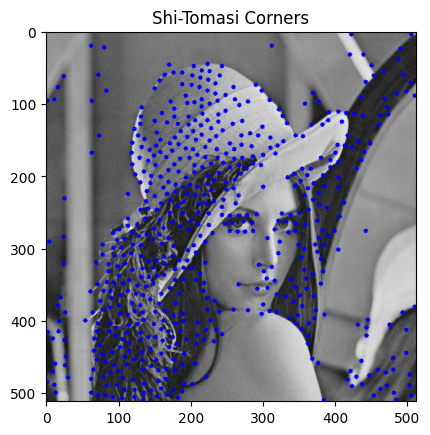

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('resources/lena_gray.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Shi-Tomasi Parameters
corners = cv2.goodFeaturesToTrack(
    gray, 
    maxCorners=1000,      # Top 100 corners
    qualityLevel=0.01,   # Minimum eigenvalue quality (relative to best)
    minDistance=10       # Minimum Euclidean distance between corners
)

# Convert corners to integers for drawing
corners = np.intp(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, (255, 0, 0), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Shi-Tomasi Corners')
plt.show()

The **FAST (Features from Accelerated Segment Test)** algorithm is a corner detector specifically designed for high-speed, real-time applications like SLAM (Simultaneous Localization and Mapping) and mobile tracking. While Harris and Shi-Tomasi are mathematically robust, they are often too slow for devices processing 60+ frames per second.

---

### 1. The Core Concept: The Segment Test

FAST works by examining a circle of 16 pixels around a candidate pixel $P$.A pixel $P$ is classified as a corner if there are $n$ contiguous pixels in the circle that are all:Brighter than $I_p + t$ (intensity of $P$ plus a threshold $t$)OR Darker than $I_p - t$Commonly, $n$ is set to 12 (FAST-12) or 9 (FAST-9).

---

### 2. The "High-Speed" Test

To make the algorithm incredibly fast, it first checks only four "compass" pixels (1, 9, 5, and 13).

1. **Check pixels 1 and 9:** If both are within the threshold (neither is significantly brighter or darker),  cannot be a corner. It is rejected immediately.
2. **Check pixels 5 and 13:** If the test continues, at least three of these four pixels must be significantly brighter or darker for  to potentially be a corner.

This simple logic allows the algorithm to reject a vast majority of non-corner pixels (like flat areas) using only a few comparisons per pixel.

---

### 3. Machine Learning Improvement

The developers of FAST used a **Decision Tree** (ID3 algorithm) to optimize the order in which pixels are checked. This "learned" version of FAST is what is typically implemented in modern libraries, as it minimizes the average number of pixel lookups required to reach a decision.

---

### 4. Weaknesses and Solutions

* **No Multi-scale:** FAST is not scale-invariant. To fix this, it is often combined with an image pyramid (as seen in the **ORB** detector).
* **Multiple Detections:** Many pixels in a small area might pass the test. **Non-Maximum Suppression (NMS)** is applied to keep only the strongest candidate.
---

### Comparison: FAST vs. Previous Detectors

| Feature | Harris / Shi-Tomasi | FAST |
| --- | --- | --- |
| **Logic** | Gradients & Eigenvalues | Pixel Intensity Comparisons |
| **Speed** | Moderate | **Extremely Fast** |
| **Robustness** | High (Rotation invariant) | Moderate (Sensitive to noise) |
| **Primary Use** | High-quality matching | Real-time tracking / SLAM |


Threshold: 10
NonmaxSuppression: True
Total Keypoints: 3906


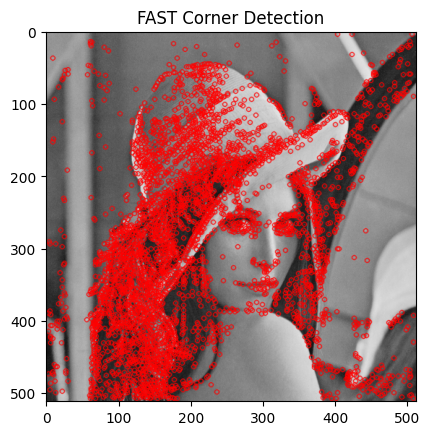

In [40]:
import cv2
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('resources/lena_gray.png', 0)

# 1. Initialize FAST object with default values
fast = cv2.FastFeatureDetector_create()

# 2. Find and draw the keypoints
kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

# Print stats
print(f"Threshold: {fast.getThreshold()}")
print(f"NonmaxSuppression: {fast.getNonmaxSuppression()}")
print(f"Total Keypoints: {len(kp)}")

plt.imshow(img2)
plt.title('FAST Corner Detection')
plt.show()
